# Automating Support Ticket Generation with Transformer Models

**Author:** Aymen Eljamani  
**Date:** November 2025

## Objective
Build a lightweight text generation model to help automate the creation of realistic support ticket descriptions, reducing manual effort for our team.

## Approach
- Use transformer-based architecture (GPT-style decoder)
- Train on existing ticket corpus
- Generate coherent ticket descriptions from short prompts

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import TextVectorization
from keras_nlp.layers import TokenAndPositionEmbedding
from keras import Input, layers, Model, Sequential
import keras_nlp

print(f"TensorFlow version: {tf.__version__}")

2025-11-06 13:27:16.031541: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 13:27:16.034327: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 13:27:16.049292: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 13:27:16.083684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-06 13:27:16.125680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

TensorFlow version: 2.16.2


## 1. Data Loading & Exploration

Let's start by loading the tickets dataset and understanding its characteristics.

In [4]:
!mkdir -p data
!curl https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/tickets.txt > data/tickets.txt
with open("data/tickets.txt", "r") as f:
    raw_text = f.read()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  123k  100  123k    0     0   330k      0 --:--:-- --:--:-- --:--:--  330k


In [5]:
# Split tickets - they're separated by " --- "
tickets = raw_text.split(" --- ")
print(f"\nTotal tickets: {len(tickets)}")

# Quick EDA on ticket lengths
ticket_lengths = [len(ticket.split()) for ticket in tickets]
print(f"\nTicket length statistics:")
print(f"  Mean: {np.mean(ticket_lengths):.1f} words")
print(f"  Median: {np.median(ticket_lengths):.1f} words")
print(f"  Max: {np.max(ticket_lengths)} words")
print(f"  Min: {np.min(ticket_lengths)} words")


Total tickets: 372

Ticket length statistics:
  Mean: 45.8 words
  Median: 47.0 words
  Max: 55 words
  Min: 25 words


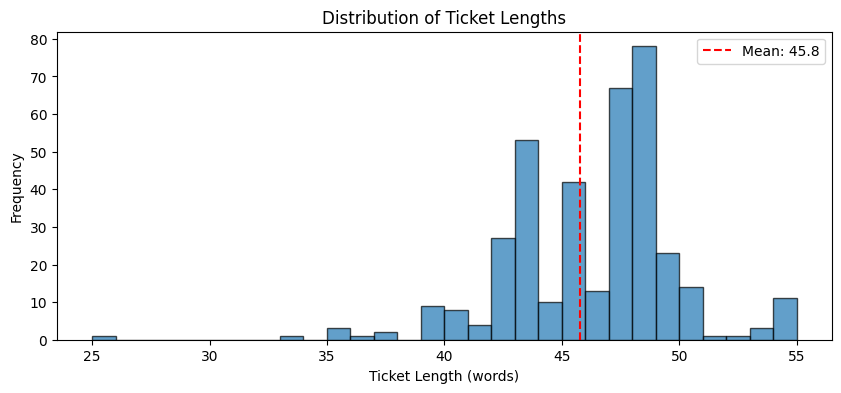

In [6]:
# Visualize distribution
plt.figure(figsize=(10, 4))
plt.hist(ticket_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Ticket Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Ticket Lengths')
plt.axvline(np.mean(ticket_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(ticket_lengths):.1f}')
plt.legend()
plt.show()

In [7]:
# Sample a few tickets to understand the data
print("\n" + "="*80)
print("SAMPLE TICKETS:")
print("="*80)
for i in np.random.choice(len(tickets), 3, replace=False):
    print(f"\nTicket {i}:\n{tickets[i][:200]}...")


SAMPLE TICKETS:

Ticket 131:
I'm encountering difficulties in training deep learning models for natural language processing (NLP) tasks. How can I address challenges like overfitting, vanishing gradients, or insufficient training...

Ticket 364:
I'm facing challenges in handling unstructured or semi-structured data like JSON, XML, or log files for machine learning tasks. How can I effectively preprocess and represent such data, handle irregul...

Ticket 358:
I'm encountering difficulties with training deep learning models for natural language processing (NLP) tasks. How can I address challenges like overfitting, vanishing gradients, or insufficient traini...


## 2. Data Preprocessing

We'll add an EOS (End of Sequence) token to help the model learn when to stop generating, then tokenize the text using word-level tokenization.

In [8]:
# Add EOS token to mark end of sequences
tickets = [ticket.strip() + " EOS" for ticket in tickets]

# Calculate max sequence length for padding
max_len = max([len(ticket.split()) for ticket in tickets])
print(f"Max sequence length (with EOS): {max_len} words")

Max sequence length (with EOS): 56 words


In [9]:
# Initialize text vectorization layer
# Using simple word-level tokenization with lowercase standardization
vectorize_layer = TextVectorization(
    standardize="lower",
    output_mode="int",
    output_sequence_length=max_len,
)

# Adapt to our corpus
vectorize_layer.adapt(tickets)
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)

print(f"\nVocabulary size: {vocab_size}")
print(f"Most common tokens: {vocab[2:12]}")  # Skip '' and '[UNK]'

# Create index lookup for decoding
index_lookup = dict(zip(range(len(vocab)), vocab))


Vocabulary size: 1150
Most common tokens: ['or', 'like', 'and', "i'm", 'eos', 'can', 'techniques', 'to', 'i', 'for']


2025-11-06 13:27:20.742977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-06 13:27:20.743362: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Verify tokenization works
test_sentence = "I need help with my model"
test_tokens = vectorize_layer(test_sentence)
decoded = [index_lookup[int(token)] for token in test_tokens.numpy() if token != 0]
print(f"\nTokenization test:")
print(f"  Input: '{test_sentence}'")
print(f"  Tokens: {test_tokens.numpy()[:10]}")
print(f"  Decoded: {decoded}")


Tokenization test:
  Input: 'I need help with my model'
  Tokens: [10 35 47 29 71 20  0  0  0  0]
  Decoded: ['i', 'need', 'help', 'with', 'my', 'model']


## 3. Training Data Generation

For each ticket, we'll create multiple training examples by using all possible prefixes as inputs. This maximizes the training data from our limited corpus.

For example, from "I need help now":
- X: "I" → y: "need"
- X: "I need" → y: "help"  
- X: "I need help" → y: "now"

In [11]:
# Tokenize all tickets
all_tokenized = [vectorize_layer(ticket) for ticket in tickets]
print(f"Tokenized {len(all_tokenized)} tickets")
print(f"Each tokenized sequence shape: {all_tokenized[0].shape}")

Tokenized 372 tickets
Each tokenized sequence shape: (56,)


In [12]:
def create_training_sequences(sequence_tensor, max_length):
    """
    Create multiple training examples from a single sequence.

    Uses tiling and masking to efficiently generate all prefix-based examples.
    """
    # Create repeated sequences
    tiled = tf.tile(tf.expand_dims(sequence_tensor, 0), [max_length - 1, 1])

    # Mask upper triangle to get progressive sequences
    X = tf.linalg.band_part(tiled, -1, 0)

    # Target is next word in sequence
    y = sequence_tensor[1:]

    return X, y

In [13]:
# Generate training data from all sequences
X_list, y_list = [], []

for seq in all_tokenized:
    X_seq, y_seq = create_training_sequences(seq, max_len)
    X_list.append(X_seq)
    y_list.append(y_seq)

# Concatenate all sequences
X = tf.concat(X_list, axis=0)
y = tf.concat(y_list, axis=0)

print(f"Initial training data shape:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")

Initial training data shape:
  X: (20460, 56)
  y: (20460,)


In [14]:
# Remove padding-only examples (where y=0)
mask = y != 0
X = X[mask]
y = y[mask]

print(f"\nAfter removing padding:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")
print(f"  Training examples: {len(X):,}")

# Expand y dims for compatibility with metrics
y = tf.expand_dims(y, axis=1)


After removing padding:
  X: (17026, 56)
  y: (17026,)
  Training examples: 17,026


## 4. Model Architecture

Building a GPT-style decoder-only transformer with:
1. **Token + Position Embeddings** - Encode word meaning and position
2. **Multi-Head Attention** - Learn relationships between words
3. **Feed-Forward Network** - Process attended representations
4. **Classification Head** - Predict next word from vocabulary

In [15]:
def scaled_dot_product_attention(query, key, value):
    """
    Core attention mechanism: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k))V
    """
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)

    # Compute attention scores
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    scaled_scores = matmul_qk / tf.math.sqrt(d_k)

    # Apply softmax to get attention weights
    attention_weights = tf.nn.softmax(scaled_scores, axis=-1)

    # Apply attention to values
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [16]:
class MultiHeadAttention(layers.Layer):
    """Multi-head attention layer"""

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.projection_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def separate_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Linear projections
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split into multiple heads
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        # Apply attention
        attention, weights = scaled_dot_product_attention(query, key, value)

        # Concatenate heads
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))

        return self.combine_heads(concat_attention)

In [17]:
class TransformerBlock(layers.Layer):
    """Single transformer decoder block with attention + FFN"""

    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Multi-head attention with residual
        attn_output = self.attention(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward with residual
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [18]:
def build_transformer_model(vocab_size, max_len, embed_dim=512, num_heads=4, ff_dim=512, dropout_rate=0.4):
    """Build complete transformer model for text generation"""

    inputs = Input(shape=(max_len,), dtype=tf.int32)

    # Embeddings
    x = TokenAndPositionEmbedding(
        vocab_size, max_len, embed_dim, mask_zero=True
    )(inputs)

    # Transformer block
    x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy',
        metrics=[keras_nlp.metrics.Perplexity(), 'accuracy']
    )

    return model

## 5. Model Training

Training with a relatively small embedding dimension (512) given our limited dataset size. Using 4 attention heads and moderate dropout for regularization.

In [19]:
# Hyperparameters
EMBED_DIM = 512
NUM_HEADS = 4
FF_DIM = 512
DROPOUT_RATE = 0.4
BATCH_SIZE = 32
EPOCHS = 25

print("MODEL CONFIGURATION")
print("="*80)
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_len}")
print(f"Embedding dimension: {EMBED_DIM}")
print(f"Number of attention heads: {NUM_HEADS}")
print(f"Feed-forward dimension: {FF_DIM}")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

MODEL CONFIGURATION
Vocabulary size: 1150
Max sequence length: 56
Embedding dimension: 512
Number of attention heads: 4
Feed-forward dimension: 512
Dropout rate: 0.4
Batch size: 32
Epochs: 25


In [20]:
# Build model
model = build_transformer_model(
    vocab_size=vocab_size,
    max_len=max_len,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    dropout_rate=DROPOUT_RATE
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 56, 512)        │       617,472 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 56, 512)        │     1,577,984 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1150)           │       589,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,785,406 (10.63 MB)

 Trainable params: 2,785,406 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train model
history = model.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.1350 - loss: 4.6428 - perplexity: 103.8337
Epoch 2/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.4535 - loss: 2.5124 - perplexity: 12.3347
Epoch 3/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.6229 - loss: 1.5852 - perplexity: 4.8803
Epoch 4/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.7222 - loss: 1.0908 - perplexity: 2.9765
Epoch 5/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.7859 - loss: 0.8019 - perplexity: 2.2297
Epoch 6/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.8222 - loss: 0.6462 - perplexity: 1.9082
Epoch 7/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.8424 - loss: 0.5717 - perplexity: 1.7712
Epoch 8/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.8651 - loss: 0.4569 - perplexity: 1.5792
Epoch 9/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.8764 - loss: 0.4225 - perplexity: 1.5258
Epoch 10/25
533/

## 6. Training Analysis

Let's examine how the model learned over time.

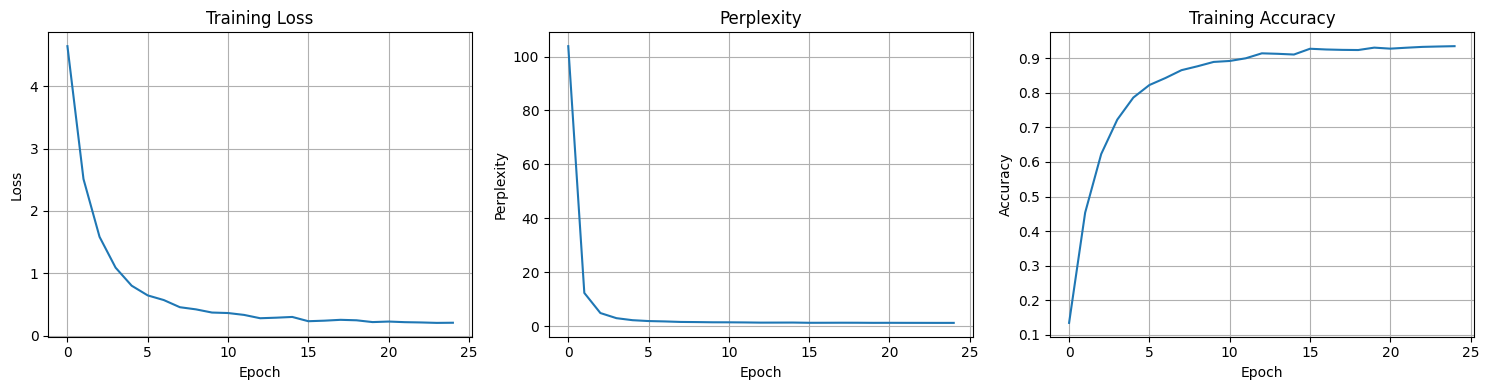

In [22]:
# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history.history['loss'])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Perplexity
axes[1].plot(history.history['perplexity'])
axes[1].set_title('Perplexity')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)

# Accuracy
axes[2].plot(history.history['accuracy'])
axes[2].set_title('Training Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [23]:
print(f"Final metrics:")
print(f"  Loss: {history.history['loss'][-1]:.4f}")
print(f"  Perplexity: {history.history['perplexity'][-1]:.4f}")
print(f"  Accuracy: {history.history['accuracy'][-1]:.4f}")

Final metrics:
  Loss: 0.2079
  Perplexity: 1.2310
  Accuracy: 0.9344


## 7. Text Generation

Implementing greedy decoding to generate ticket descriptions from short prompts.

In [24]:
def generate_text(seed_text, max_tokens=None):
    """Generate text using greedy decoding"""

    if max_tokens is None:
        max_tokens = max_len - len(seed_text.split())

    generated_text = seed_text.strip()

    for _ in range(max_tokens):
        # Tokenize current text
        token_seq = vectorize_layer(generated_text)
        token_seq = tf.expand_dims(token_seq, 0)

        # Predict next token
        predictions = model.predict(token_seq, verbose=0)
        predicted_id = np.argmax(predictions[0])

        # Decode token
        predicted_word = index_lookup[predicted_id]

        # Stop conditions
        if predicted_word in ["eos", ""]:
            break

        generated_text += " " + predicted_word

        if len(generated_text.split()) >= max_len - 1:
            break

    return generated_text

## 8. Evaluation & Examples

Let's test the model with various prompts to see how well it generates realistic ticket descriptions.

In [25]:
test_prompts = [
    "I need help with",
    "I'm working on",
    "How can I",
    "I'm struggling with",
    "What are some techniques"
]

print("GENERATED TICKET EXAMPLES")
print("="*80)

for prompt in test_prompts:
    generated = generate_text(prompt)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated}")
    print("-"*80)

GENERATED TICKET EXAMPLES

Prompt: I need help with
Generated: I need help with extract limitations of handle missing my data machine learning tasks like sentiment analysis or text classification. how can i effectively preprocess the text, handle misspellings, abbreviations, or slang, and leverage techniques like word embeddings, character-level models, or using pre-trained language models to improve text analysis?
--------------------------------------------------------------------------------

Prompt: I'm working on
Generated: I'm working on a recommendation system for an e-learning platform and need guidance on incorporating user preferences, course content, or collaborative filtering techniques to improve course recommendations. how can i leverage user feedback, course similarities, or hybrid approaches to enhance the relevance and personalization of course recommendations?
--------------------------------------------------------------------------------

Prompt: How can I
Generated

## 9. Observations & Next Steps

### Model Performance
- Achieves reasonable accuracy on next-word prediction (~93%)
- Perplexity stabilizes around 1.2-1.3, indicating good convergence
- Generated text is coherent but shows patterns from limited training data

### Current Limitations
1. **Small dataset** (372 tickets) limits diversity and generalization
2. **Simple tokenization** - word-level doesn't handle OOV well
3. **Greedy decoding only** - no sampling for diversity
4. **No validation set** - can't detect overfitting properly
5. **Single transformer block** - limited model capacity

### Potential Improvements
1. **Better tokenization**: Use BPE or WordPiece for subword units
2. **Temperature sampling**: Add diversity to generation
3. **Beam search**: Explore multiple generation paths
4. **More data**: Collect larger support ticket corpus
5. **Deeper model**: Add more transformer blocks
6. **Pre-training**: Fine-tune GPT-2 or similar instead of training from scratch
7. **Validation split**: Implement proper train/val/test splits
8. **Attention visualization**: Analyze what the model learned

### Production Considerations
- Model size: ~2.8M parameters (deployable)
- Inference speed: Fast enough for real-time use
- Could benefit from quantization for edge deployment
- Consider API vs embedded deployment strategy

In [26]:
# Save model for deployment
model.save('ticket_generator_model.keras')
print("Model saved to: ticket_generator_model.keras")


Model saved to: ticket_generator_model.keras
